In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import time
import datetime
import calendar
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from imblearn.under_sampling import *
from imblearn.over_sampling import *
from imblearn.combine import *
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
import lightgbm 
from sklearn.preprocessing import PolynomialFeatures

/Users/by/.pyenv/versions/3.6.6/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


<img src="images/noshow_cover.jpg" alt="cover" style="width: 1500px;"/>

# 1) 데이터 소개

- 브라질의 병원의 진료예약에 관한 데이터로서, 그 중에서도 주로 이스피리투산투주에 있는 병원의 기록이 대다수이다. 예측하고자 하는 Target variable은 No-show의 여부이다. 

- 진료예약을 하는 사람들중에 아파서 병원에 꼭 방문해야 할 사람들은 어떤 일이 있어도 방문을 하기 때문에 병원의 입장에서는 상대적으로 진료예약을 하고 진료를 받으러 오지 않는 고객들이 많아질수록 더 큰 손해이기 때문에 병원의 No-show 고객에 의한 손실비용을 최소화하기 위해 recall을 높이는데 중점을 둘것이다.

링크주소 : [kaggle data link](https://www.kaggle.com/joniarroba/noshowappointments)

# variable

- PatientId : 환자에 대한 식별자
- AppointmentID : 예약에 대한 식별자
- Gender : 성별 (F:여성, M:남성)
- ScheduledDay : 진료예약을 접수한 날짜(연, 월, 일, 시, 분, 초를 포함)
- AppointmentDay : 실제 진료 예약 날짜(진료를 받는날) (연, 월, 일을 포함) 
- Age : 환자의 나이
- Neighbourhood : 병원이 있는 지명
- Scholarship : 가족수당을 받는지에 대한 여부 (https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia)
- Hipertension : 고혈압의 여부 (0 :고혈압이 없음, 1:고혈압이 있음)
- Diabetes : 당뇨병 여부 (당뇨병이 없음, 1:당뇨병이 있음)
- Alcoholism : 알코올 중독의 여부 (0:알코올 중독증상이 없음, 1:알코올 중독증상이 있음)
- Handcap : 장애의 수 (0,1,2,3,4개)
- SMS_received : 1건 또는 그 이상 메세지를 환자에게 보냈는지의 여부 (0: 환자에게 메세지를 보내지 않음, 1: 환자에게 메세지를 보냄)
- No-show : 진료예약한 날짜에 진료를 받기위해 나타났는지의 여부. (Yes: 오지 않음, No: 병원 방문함)

In [6]:
df=pd.read_csv("noshow.csv")
df.tail()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
110522,2.572134e+12,5651768,F,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,3.596266e+12,5650093,F,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,1.557663e+13,5630692,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,9.213493e+13,5630323,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No
110526,3.775115e+14,5629448,F,2016-04-27T13:30:56Z,2016-06-07T00:00:00Z,54,MARIA ORTIZ,0,0,0,0,0,1,No


# No-show

- 데이터가 imbalanced data 문제를 가지고 있음을 확인할 수 있다.

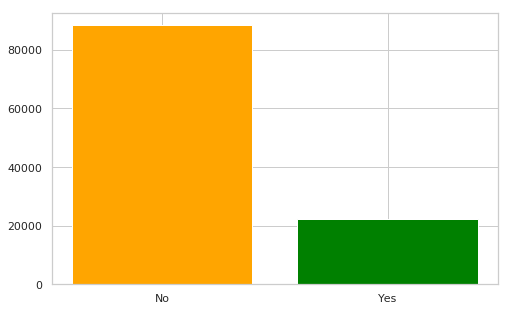

In [7]:
df1=df.groupby(["No-show"]).size().reset_index(name="count")
plt.figure(figsize=(8,5))
plt.bar(df1["No-show"], height=df1["count"], color=["orange","green"])
plt.show()
del(df1)

# PatientId

- 데이터는 62,299명의 진료예약에 관한 정보를 담고 있음을 알 수 있다. 그러므로 동일한 인원이 받은 기록이 있음을 확인 할 수 있다.
- 전체 데이터에서 한번만 방문한 비율은 전체 데이터에서 34.3%이다.

In [8]:
df.PatientId=df.PatientId.astype(int)
print("환자들의 수 : {} 명".format(len(set(df.PatientId))))
print("전체 데이터에서 예약 접수가 1건인 비율 : {} %".format(round(sum(df.groupby(["PatientId"]).size() == 1)/len(df), 4)*100))
print("전체 데이터에서 예약 접수가 2건인 비율 : {} %".format(round(sum(df.groupby(["PatientId"]).size() == 2)/len(df), 4)*100))

환자들의 수 : 62299 명
전체 데이터에서 예약 접수가 1건인 비율 : 34.31 %
전체 데이터에서 예약 접수가 2건인 비율 : 12.57 %


#  AppointmentId

- 레코드의 식별자 역할은 PatientId가 아닌 AppointmentId이다.

- AppointmentID는 진료예약 접수 시간에 의존함을 확인할 수 있다.

                                        
총 예약 건수 : 110527 개
                                        


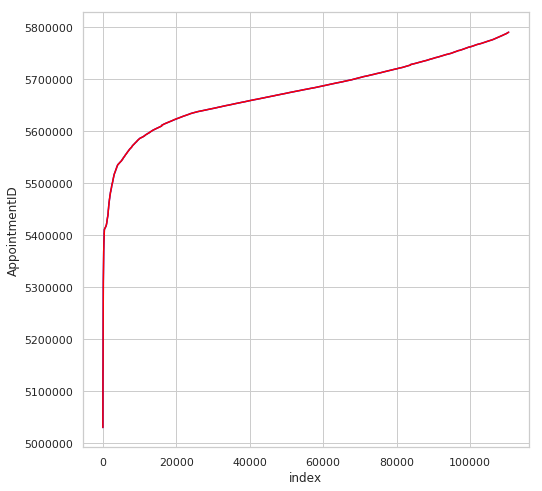

In [9]:
print(" "*40)
print("총 예약 건수 : {} 개".format(len(set(df.AppointmentID))))
print(" "*40)
plt.figure(figsize=(8,8))
plt.xlabel("index")
plt.ylabel("AppointmentID")
plt.plot(df.sort_values(by=["ScheduledDay"])["AppointmentID"].values, color="blue")
plt.plot(df.sort_values(by=["AppointmentID"])["AppointmentID"].values, color="red")
plt.show()

In [10]:
def cal_probNoshow(data, group_by):
    df = pd.crosstab(index = data[group_by], columns = data["No-show"]).reset_index()
    df["probNoshow"] = df["Yes"] / (df["No"] + df["Yes"])
    return df

# ScheduledDay & AppointmentDay

In [11]:
df["scheduled_Year"] = pd.to_datetime(df.ScheduledDay).apply(lambda x: x.year)
df["scheduled_month"] = pd.to_datetime(df.ScheduledDay).apply(lambda x: x.month)
df["scheduled_day"] = pd.to_datetime(df.ScheduledDay).apply(lambda x: x.day)
df["scheduled_Hour"] = pd.to_datetime(df.ScheduledDay).apply(lambda x: x.hour)
df["scheduled_dayofweek"] = pd.to_datetime(df.ScheduledDay)\
.apply(lambda x : calendar.weekday(x.timetuple().tm_year, x.timetuple().tm_mon, x.timetuple().tm_mday))

df["appoint_Year"] = pd.to_datetime(df.AppointmentDay).apply(lambda x: x.year)
df["appoint_month"] = pd.to_datetime(df.AppointmentDay).apply(lambda x: x.month)
df["appoint_day"] = pd.to_datetime(df.AppointmentDay).apply(lambda x: x.day)
df["appoint_dayofweek"] = pd.to_datetime(df.AppointmentDay)\
.apply(lambda x : calendar.weekday(x.timetuple().tm_year, x.timetuple().tm_mon, x.timetuple().tm_mday))

df.ScheduledDay=pd.to_datetime(df.ScheduledDay.apply(lambda x : x[:10]))
df.AppointmentDay=pd.to_datetime(df.AppointmentDay.apply(lambda x : x[:10]))

# differ_day

- 진료예약을 접수한날과 진료날짜의 차이를 구하였다. 그 중 예약날짜와 예약날간의 차이가 음수인 데이터를 제거해주었다.

- No-show의 여부에 따른 예약접수날짜와 진료날짜의 차이에 대한 분포를 살펴보면 차이가 0인 즉 당일 접수하고 진료를 받는 데이터들가 전체의 25%를차지하고 있음을 확인할 수 있다.

- 3사분위수와 최대값의 차이가 많이 나는데 Q3 + IQR*1.5 = 37.5 일을 기준으로 하나는 전체 데이터를 포함하고 lmplot을 그려보고 다른 하나는 37.5일 이하인 데이터로 lmplot을 그려 보았을 때, 전체 데이터에서의 5%로 인해 나머지 95%의 데이터가 가지는 선형성을 깨버리고 있다고 판단하여 병원측 관계자의 입장으로 보았을때, 예약 환자의 95%의 No-show에 영향을 미치는 feature를 찾아내는 것이 효용이 높으므로 37.5 일 보다 큰 데이터들은 제거한다.

In [12]:
df["differ_day"] = pd.Series(df.AppointmentDay-df.ScheduledDay).apply(lambda x : x.days)
print(" "*40)
print(df.groupby(by=["differ_day","No-show"]).size().reset_index(name="count")[:2])
df=df[df.differ_day >=0]
df.reset_index(inplace=True,drop=True)
print(" "*40)
print(df.describe()["differ_day"])
print(" "*40)
IQR=np.percentile(df["differ_day"], 75)-np.percentile(df["differ_day"], 25)
Q3=np.percentile(df["differ_day"], 75)
outstart=IQR*1.5+Q3
print("Q3 + IQR*1.5 = {} 일".format(outstart))
print(" "*40)
print("IQR*1.5+Q3보다 큰 데이터의 비율 : {} %".format(np.round(len(df[df["differ_day"]>outstart])/len(df)*100),4))

                                        
   differ_day No-show  count
0          -6     Yes      1
1          -1     Yes      4
                                        
count    110522.000000
mean         10.184253
std          15.255115
min           0.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: differ_day, dtype: float64
                                        
Q3 + IQR*1.5 = 37.5 일
                                        
IQR*1.5+Q3보다 큰 데이터의 비율 : 5.0 %


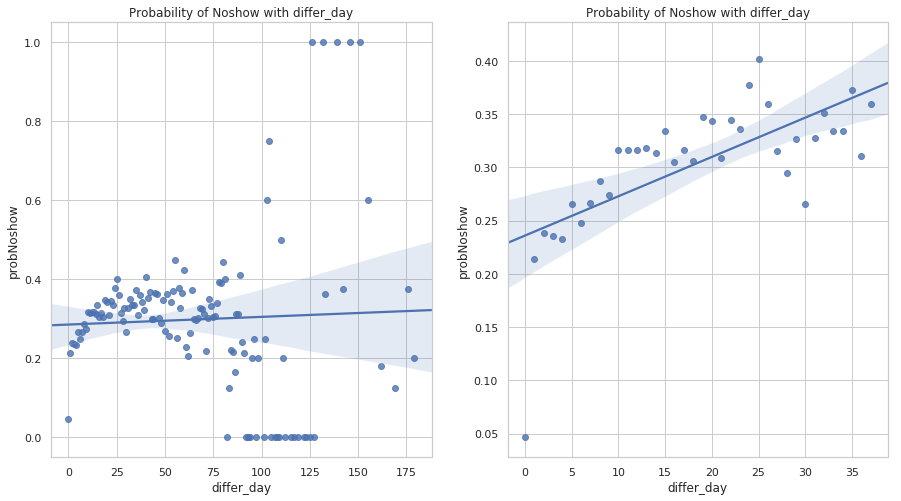

In [13]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
plt.subplot(1,2,1)
sns.regplot(data = cal_probNoshow(df, 'differ_day'), x = 'differ_day', y = 'probNoshow', fit_reg = True)
# plt.xlim(0, 100)
plt.title('Probability of Noshow with differ_day')
plt.subplot(1,2,2)
sns.regplot(data = cal_probNoshow(df[df["differ_day"]<=outstart], 'differ_day'), x = 'differ_day', y = 'probNoshow', fit_reg = True)
# plt.xlim(0, 100)
plt.title('Probability of Noshow with differ_day')
plt.show()

위에서 찾아본 differ_day의 3사분위수가 13이므로 13을 기준으로 나누어서 No-show의 확률을 비교해보니 상대적으로 yes의 확률이 즉, No-show할 확률은 2배이상 늘어나는데 비해서 No-show하지 않을 확률은 배이상 늘어나지 않는다. 그러므로 이 기준을 데이터에 적용시켜 새로운 feature인 2주이내에 예약했는지 안했는지의 여부를 만들어서 모형에 적합시키면, 크기가 작은 Yes의 데이터에 대해 좀더 잘 분류해줄 수 있을 것이라는 가정하에 새로운 feature를 만들어 준다.

In [14]:
df=df[df["differ_day"]<=outstart]
print(" "*50)
print(df.describe()["differ_day"])
print(" "*50)
print("14일 이후에 예약한 사람들의 No-show할 확률")
print(df[df.differ_day>=14].groupby(["No-show"]).size()/len(df[df.differ_day>14]))
print(" "*50)
print("14일 이내에 예약한 사람들의 No-show할 확률")
print(df[df.differ_day<14].groupby(["No-show"]).size()/len(df[df.differ_day<=14]))
df["No_within_2week"]= df.differ_day.apply(lambda x : 0 if x <= 13 else 1)

                                                  
count    104719.000000
mean          7.590227
std           9.876124
min           0.000000
25%           0.000000
50%           3.000000
75%          13.000000
max          37.000000
Name: differ_day, dtype: float64
                                                  
14일 이후에 예약한 사람들의 No-show할 확률
No-show
No     0.761779
Yes    0.370956
dtype: float64
                                                  
14일 이내에 예약한 사람들의 No-show할 확률
No-show
No     0.816027
Yes    0.148780
dtype: float64


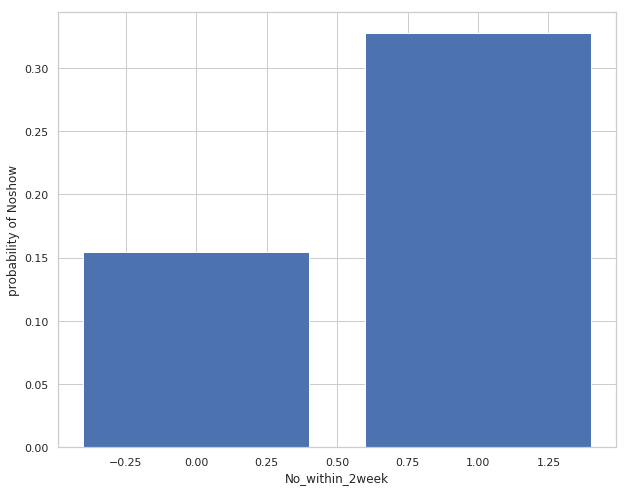

In [15]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
plt.xlabel("No_within_2week")
plt.ylabel("probability of Noshow")
plt.bar(x=list(cal_probNoshow(df, "No_within_2week")["No_within_2week"].values), height=cal_probNoshow(df, "No_within_2week")["probNoshow"],\
        width=0.8)
plt.show()

# scheduled_Year & appoint_Year

- "scheduled_Year"와 "appoint_Year"의 값은 2016년 밖에 없기 때문에 컬럼을 제거해준다.

In [16]:
print("접수하는 년도 : {} 년".format(list(set(df.scheduled_Year))[0]))
print("진료받는 년도 : {} 년".format(list(set(df.appoint_Year))[0]))
df=df.drop(columns=["scheduled_Year", "appoint_Year"])

접수하는 년도 : 2016 년
진료받는 년도 : 2016 년


# scheduled_month & appoint_month

- 실질적으로 예약을 하고 진료를 받으러오는 날은 2016년 4,5,6월의 데이터만 존재함을 확인할 수 있다.

In [17]:
print("접수하는 월 : {} 월".format(set(df.scheduled_month)))
print("진료하는 월 : {} 월".format(set(df.appoint_month)))

접수하는 월 : {3, 4, 5, 6} 월
진료하는 월 : {4, 5, 6} 월


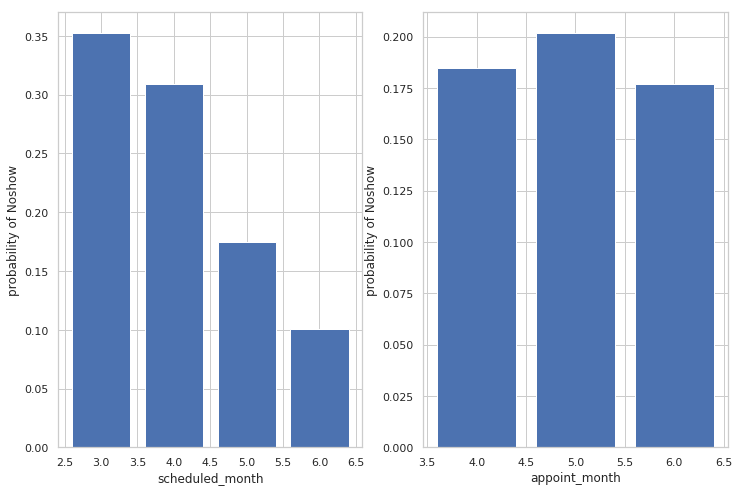

In [18]:
plt.subplots(1,2, figsize=(12,8))
plt.subplot(1,2,1)
plt.xlabel("scheduled_month")
plt.ylabel("probability of Noshow")
plt.bar(x=list(cal_probNoshow(df, "scheduled_month")["scheduled_month"].values), height=cal_probNoshow(df, "scheduled_month")["probNoshow"],\
        width=0.8)
# plt.xticks(list(cal_probNoshow(df, "appoint_month")["appoint_month"].values), ["4","5","6"])
plt.subplot(1,2,2)
plt.xlabel("appoint_month")
plt.ylabel("probability of Noshow")
plt.bar(x=list(cal_probNoshow(df, "appoint_month")["appoint_month"].values), height=cal_probNoshow(df, "appoint_month")["probNoshow"], width=0.8)
# plt.xticks(list(cal_probNoshow(df, "appoint_month")["appoint_month"].values), ["4","5","6"])
plt.show()

# scheduled_dayofweek & appoint_dayofweek

- 일요일은 예약과 진료를 모두 안한다는 것을 확인 할 수 있다.

In [19]:
print("접수하는 요일 : {}".format(set(df.scheduled_dayofweek)))
print("진료받는 요일 : {}".format(set(df.appoint_dayofweek)))
df["No_saturday_sch"] = df.scheduled_dayofweek.apply(lambda x : 0 if x == 5 else 1)
df["new_appoint_dayofweek"] = df.appoint_dayofweek.apply(lambda x : 0 if x <= 3 else 1)

접수하는 요일 : {0, 1, 2, 3, 4, 5}
진료받는 요일 : {0, 1, 2, 3, 4, 5}


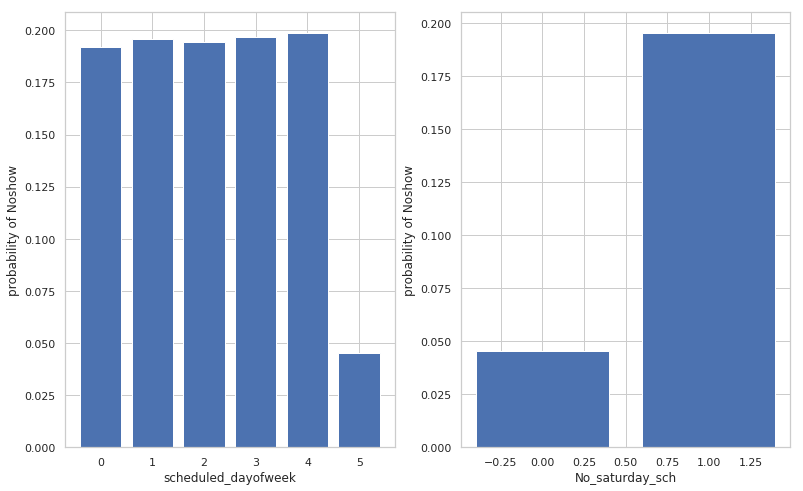

In [20]:
fig, ax = plt.subplots(1,2,figsize=(13,8))
plt.subplot(1,2,1)
plt.xlabel("scheduled_dayofweek")
plt.ylabel("probability of Noshow")
plt.bar(x=list(cal_probNoshow(df, "scheduled_dayofweek")["scheduled_dayofweek"].values), \
        height=cal_probNoshow(df, "scheduled_dayofweek")["probNoshow"], width=0.8)

plt.subplot(1,2,2)
plt.xlabel("No_saturday_sch")
plt.ylabel("probability of Noshow")
plt.bar(x=list(cal_probNoshow(df, "No_saturday_sch")["No_saturday_sch"].values), \
        height=cal_probNoshow(df, "No_saturday_sch")["probNoshow"], width=0.8)
plt.show()

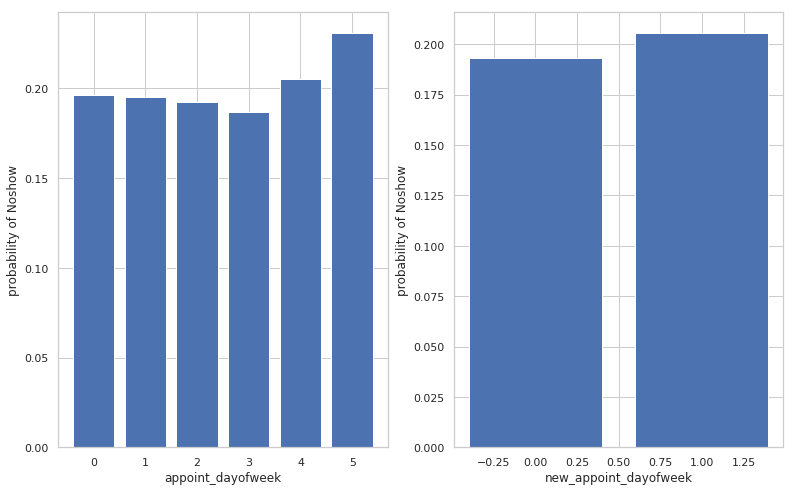

In [21]:
fig, ax = plt.subplots(1,2,figsize=(13,8))

plt.subplot(1,2,1)
plt.xlabel("appoint_dayofweek")
plt.ylabel("probability of Noshow")
plt.bar(x=list(cal_probNoshow(df, "appoint_dayofweek")["appoint_dayofweek"].values), \
        height=cal_probNoshow(df, "appoint_dayofweek")["probNoshow"], width=0.8)

plt.subplot(1,2,2)
plt.xlabel("new_appoint_dayofweek")
plt.ylabel("probability of Noshow")
plt.bar(x=list(cal_probNoshow(df, "new_appoint_dayofweek")["new_appoint_dayofweek"].values), \
        height=cal_probNoshow(df, "new_appoint_dayofweek")["probNoshow"], width=0.8)

plt.show()
df=df.drop(columns=["new_appoint_dayofweek"])

# scheduled_Hour

접수하는 시간 : {6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21} 시


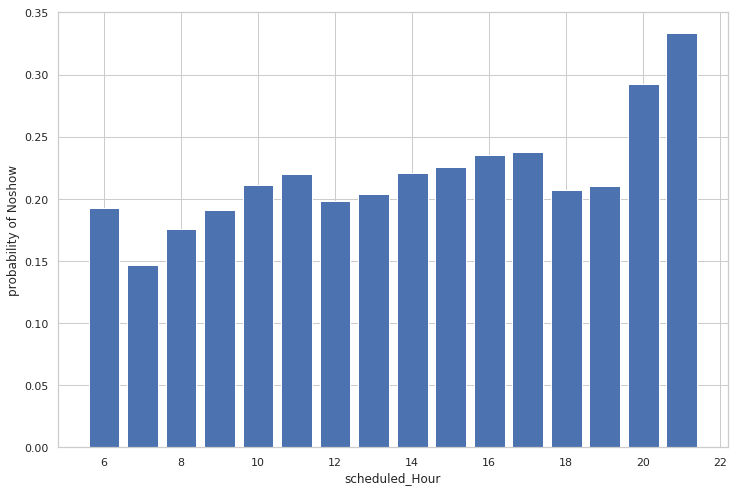

In [22]:
print("접수하는 시간 : {} 시".format(set(df.scheduled_Hour)))
plt.figure(figsize=(12,8))
plt.xlabel("scheduled_Hour")
plt.ylabel("probability of Noshow")
plt.bar(x=list(cal_probNoshow(df, "scheduled_Hour")["scheduled_Hour"].values), height=cal_probNoshow(df, "scheduled_Hour")["probNoshow"], \
        width=0.8)
plt.show()

# Age

- 나이가 음수인 것이 존재하는 것을 확인 할 수 있다. 

- 여성이므로 나이가 -1인것은 임산부가 태아의 진료를 받으려고 예약한 자료라고 추측 해 볼 수 있을 것이다. 허나 정확히 임산부인지를 알 수 있을 만한 자료가 -1인 데이터가 하나만 존재하며 이 데이터의 PatientId와 동일한 다른 데이터가 있는지 확인 한 후에 있다면 그 데이터의 나이를 확인해 보려 하였으나, 데이터가 임산부의 데이터라는 것을 뒷받침할만한 근거가 없으므로 제거해줄것이다. 

- 결론적으로 0세이상인 데이터만을 사용할 것이다.

- 또한 위에서 살펴본 것처럼 3사분위수와 최대값의 차이가 너무 크다는 것과 위의 그래프에서 오른쪽 최상단의 데이터들에 의해 회귀직선식이 당겨져 있음을 확인 할 수 있어 Q3 + IQR*1.5 보다 큰 나이를 가진 5건의 데이터를 제거해줄 것이다.

In [23]:
print(" "*40)
print(df.describe()["Age"])
print(" "*40)
df=df[df.Age >=0]
df.reset_index(inplace=True,drop=True)
IQR=np.percentile(df["Age"], 75)-np.percentile(df["Age"], 25)
outstart=IQR*1.5+np.percentile(df["Age"], 75)
print("Q3+IQR*1.5 = {} 세".format(outstart))
print(" "*40)
print("IQR*1.5+Q3보다 큰 데이터의 개수 : {} 개".format(len(df.iloc[np.where(df.Age > outstart)])))

                                        
count    104719.000000
mean         36.852672
std          23.058111
min          -1.000000
25%          17.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: Age, dtype: float64
                                        
Q3+IQR*1.5 = 112.0 세
                                        
IQR*1.5+Q3보다 큰 데이터의 개수 : 4 개


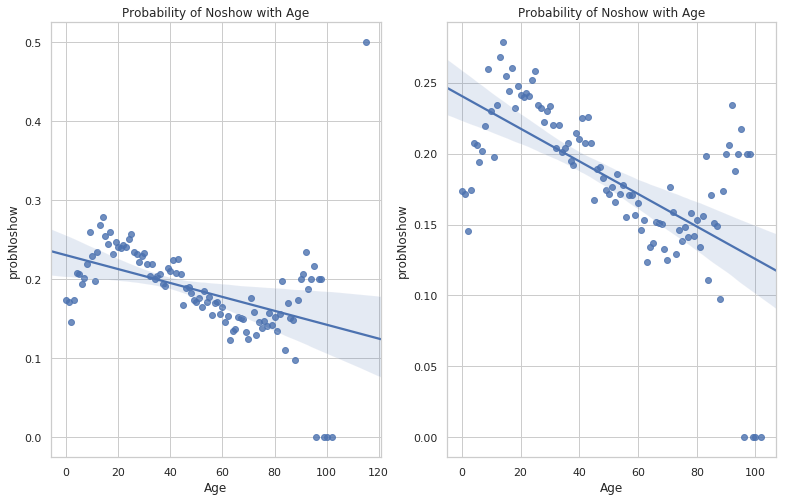

In [24]:
fig, ax = plt.subplots(1,2,figsize=(13,8))
plt.subplot(1,2,1)
sns.regplot(data = cal_probNoshow(df, 'Age'), x = 'Age', y = 'probNoshow', fit_reg = True)
plt.title('Probability of Noshow with Age')
plt.subplot(1,2,2)
sns.regplot(data = cal_probNoshow(df[df.Age <= outstart], 'Age'), x = 'Age', y = 'probNoshow', fit_reg = True)
plt.title('Probability of Noshow with Age')

plt.show()
df=df[df.Age <= outstart]
df.reset_index(inplace=True,drop=True)

브라질의 성년의 기준은 우리나라와 달리 18세이다. 위의 그래프를 살펴보게되면, 대략 18세를 기준으로 18세 이전까지는 보호자의 동행에 따라 자신의 의지보다는 보호자의 스케줄에 따라 예약을 하였기 때문에 상대적으로 안올 확률이 다른 나이대에 보다 크다고 생각해 볼 수 있을 것이다.

그래서 18세를 기준으로 성인여부를 나타내는 coming_of_age라는 변수를 새롭게 생성해 줄 것이다.

그 기준에 의해 성인의여부에 따른 No-show의 확률을 살펴 보면 다음과 같이 성인이 아닌 사람이 좀더 No-show할 확률이 높다는 것을 확인 할 수 있다.

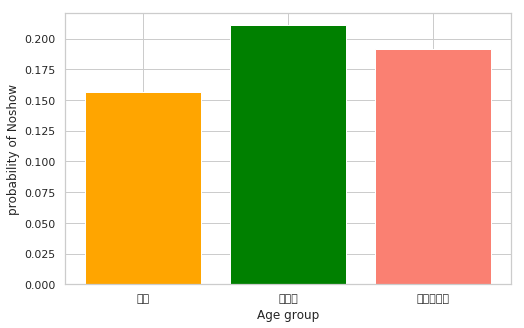

In [25]:
df["coming_of_age"]=df.Age.apply(lambda x : "미성년" if x < 18 else "청년및중년" if 18<=x<=80 else"노년")
plt.figure(figsize=(8,5))
plt.xlabel("Age group")
plt.ylabel("probability of Noshow")
plt.bar(x=["노년", "미성년", "청년및중년"], height=cal_probNoshow(df, "coming_of_age")["probNoshow"], width=0.8, color=["orange","green","salmon"])
plt.show()

# Gender

- 전체 데이터에서 여성이 71,840명, 남성이 38,687명으로  여성이 절반이상인 약 65%를 차지하고 있음을 확인 할 수 있다.

- 여성과 남성은 거의 비슷한 비율로 예약날짜에 오지 않았다는 사실을 확인 할 수 있다.

                                        
여성의 비율 : 64.86 %
남성의 비율 : 35.14 %
                                        


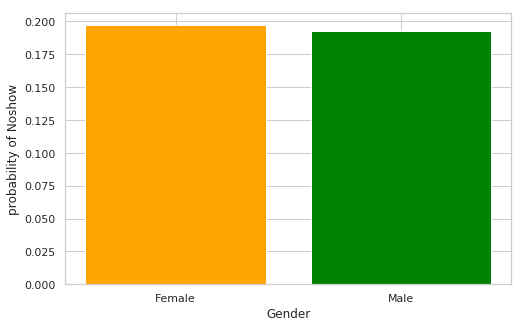

In [26]:
print(" "*40)
print("여성의 비율 : {} %".format(np.round(len(df[df.Gender=="F"])/len(df),4)*100))
print("남성의 비율 : {} %".format(np.round(len(df[df.Gender!="F"])/len(df),4)*100))
print(" "*40)
plt.figure(figsize=(8,5))
plt.xlabel("Gender")
plt.ylabel("probability of Noshow")
plt.bar(x=["Female","Male"], height=cal_probNoshow(df, "Gender")["probNoshow"], width=0.8, color=["orange","green"])
plt.show()

### Neighbourhood

- 예약한 병원의 장소

In [27]:
print("예약한 병원의 개수 : {} 개".format(len(set(df.Neighbourhood))))

예약한 병원의 개수 : 81 개


![nei1](images/nei1.png)
![con.png](images/con.png)

# Scholarship

- 정부의 경제적 지원을 받고 있는지에 대한 여부 (0: 경제적 지원을 받지 않고 있는 환자, 1: 경제적 지원을 받고 있는 환자) 

# Hipertension

- 고혈압이 없는 환자가 더 많음을 확인 할 수 있다. (0: 고혈압이 없는 환자, 1: 고혈압이 있는 환자)

# Diabetes

- 당뇨병이 없는 환자가 더 많음을 확인 할 수 있다. (0: 당뇨병이 없는 환자, 1: 당뇨병이 있는 환자)

# Alcoholism

- 알코올 중독 여부를 의미한다. (0: 알코올 중독이 아닌 환자,  1: 알코올 중독인 환자)

- 알코올 중독 여부에 따른 No-show할 확률이 같음을 확인 할 수 있다. 결론적을 알코올 중독 여부는 No-show의 여부에 크게 영향을 미치지 않는 변수라는 것을 알 수 있다. 그러므로 컬럼에서 제거해준다.

# Handcap

- 그 환자가 가지고 있는 장애의 개수를 의미한다. (0~4개)

- 장애의 갯수에 따른 No-show할 확률은 다음과 같다. 2개이하는 상대적으로 3개이상인 사람들에 비해 No-show를 하지 않을 확률이 크다.

# SMS_received

- 진료 예약 알림문자를 받은 환자를 의미한다. (0: 알코올 중독이 아닌 사람,  1: 알코올 중독인 사람)

- 각각 예약 알림문자 수신여부에 따른 No-show할 확률은 문자를 안받은 환자들이 더 많이 재방문을 한다고 할 수 있다.

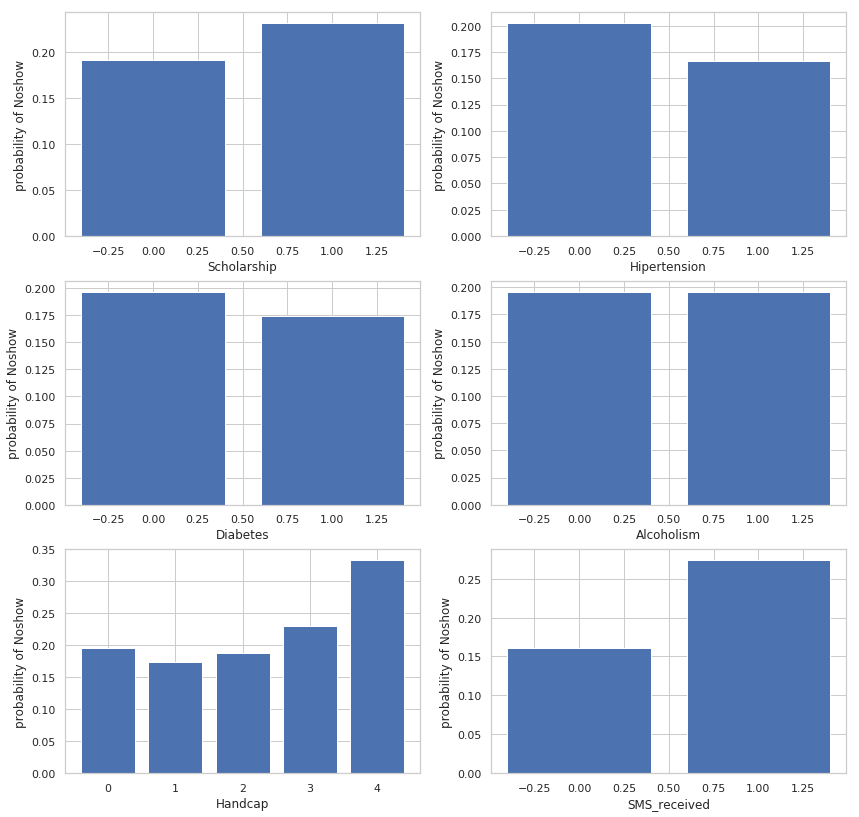

In [28]:
fig, ax = plt.subplots(3,2,figsize=(14,14))
plt.subplot(3,2,1)
plt.xlabel("Scholarship")
plt.ylabel("probability of Noshow")
plt.bar(x=list(cal_probNoshow(df, "Scholarship")["Scholarship"].values), height=cal_probNoshow(df, "Scholarship")["probNoshow"], width=0.8)

plt.subplot(3,2,2)
plt.xlabel("Hipertension")
plt.ylabel("probability of Noshow")
plt.bar(x=list(cal_probNoshow(df, "Hipertension")["Hipertension"].values), height=cal_probNoshow(df, "Hipertension")["probNoshow"], width=0.8)

plt.subplot(3,2,3)
plt.xlabel("Diabetes")
plt.ylabel("probability of Noshow")
plt.bar(x=list(cal_probNoshow(df, "Diabetes")["Diabetes"].values), height=cal_probNoshow(df, "Diabetes")["probNoshow"], width=0.8)

plt.subplot(3,2,4)
plt.xlabel("Alcoholism")
plt.ylabel("probability of Noshow")
plt.bar(x=list(cal_probNoshow(df, "Alcoholism")["Alcoholism"].values), height=cal_probNoshow(df, "Alcoholism")["probNoshow"], width=0.8)

plt.subplot(3,2,5)
plt.xlabel("Handcap")
plt.ylabel("probability of Noshow")
plt.bar(x=list(cal_probNoshow(df, "Handcap")["Handcap"].values), height=cal_probNoshow(df, "Handcap")["probNoshow"], width=0.8)

plt.subplot(3,2,6)
plt.xlabel("SMS_received")
plt.ylabel("probability of Noshow")
plt.bar(x=list(cal_probNoshow(df, "SMS_received")["SMS_received"].values), height=cal_probNoshow(df, "SMS_received")["probNoshow"], width=0.8)

plt.show()

In [29]:
print("2일이내에 예약한 사람 중 알림문자를 받은 사람 수 : {} 명".format(sum(df[df.differ_day<3].SMS_received)))
df["No_within_2days"]=df.differ_day.apply(lambda x : 1 if 2 <= x else 0)

2일이내에 예약한 사람 중 알림문자를 받은 사람 수 : 0 명


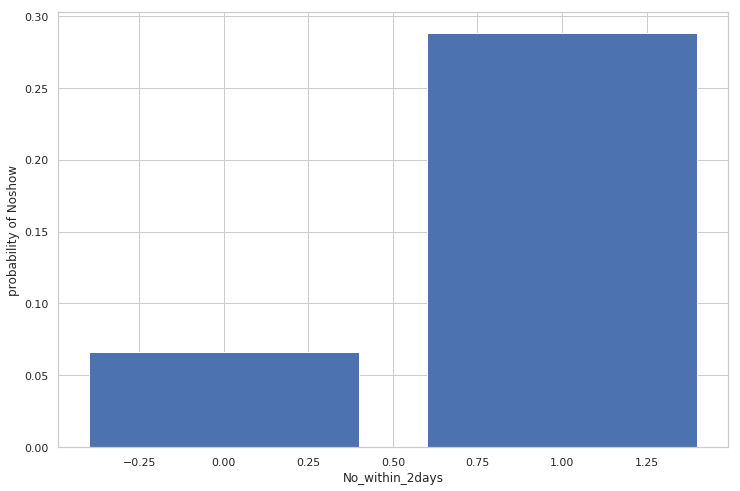

In [30]:
plt.figure(figsize=(12,8))
plt.xlabel("No_within_2days")
plt.ylabel("probability of Noshow")
plt.bar(x=list(cal_probNoshow(df, "No_within_2days")["No_within_2days"].values), \
        height=cal_probNoshow(df, "No_within_2days")["probNoshow"], width=0.8)
plt.show()
df=df.drop(columns=['AppointmentID', 'ScheduledDay', 'scheduled_day', 'appoint_day', 'Alcoholism'])

# train data & test data

In [31]:
df.columns

Index(['PatientId', 'Gender', 'AppointmentDay', 'Age', 'Neighbourhood',
       'Scholarship', 'Hipertension', 'Diabetes', 'Handcap', 'SMS_received',
       'No-show', 'scheduled_month', 'scheduled_Hour', 'scheduled_dayofweek',
       'appoint_month', 'appoint_dayofweek', 'differ_day', 'No_within_2week',
       'No_saturday_sch', 'coming_of_age', 'No_within_2days'],
      dtype='object')

In [33]:
dfX=df[list(set(list(df.columns))-set(["No-show","PatientId","AppointmentDay","Neighbourhood"]))]
dfy=df["No-show"]
non_categorical_col=["differ_day", "Age"]
categorical_col = list(set(dfX.columns)-set(non_categorical_col))

dfX1=dfX[non_categorical_col]
dfX2=pd.get_dummies(dfX[categorical_col].astype(str), drop_first=True)
dfX=pd.concat((dfX1,dfX2),axis=1)

In [34]:
print(list(dfX.columns))

['differ_day', 'Age', 'scheduled_Hour_11', 'scheduled_Hour_12', 'scheduled_Hour_13', 'scheduled_Hour_14', 'scheduled_Hour_15', 'scheduled_Hour_16', 'scheduled_Hour_17', 'scheduled_Hour_18', 'scheduled_Hour_19', 'scheduled_Hour_20', 'scheduled_Hour_21', 'scheduled_Hour_6', 'scheduled_Hour_7', 'scheduled_Hour_8', 'scheduled_Hour_9', 'SMS_received_1', 'scheduled_dayofweek_1', 'scheduled_dayofweek_2', 'scheduled_dayofweek_3', 'scheduled_dayofweek_4', 'scheduled_dayofweek_5', 'appoint_month_5', 'appoint_month_6', 'No_within_2days_1', 'Diabetes_1', 'No_within_2week_1', 'coming_of_age_미성년', 'coming_of_age_청년및중년', 'No_saturday_sch_1', 'appoint_dayofweek_1', 'appoint_dayofweek_2', 'appoint_dayofweek_3', 'appoint_dayofweek_4', 'appoint_dayofweek_5', 'Gender_M', 'Hipertension_1', 'Scholarship_1', 'scheduled_month_4', 'scheduled_month_5', 'scheduled_month_6', 'Handcap_1', 'Handcap_2', 'Handcap_3', 'Handcap_4']


1.neighbourhood 빼보기 => 성능 저하

2.성별과 나이그룹별 상호작용 추가 => 성능 저하

3) 1,2번 동시에 해보기 => 성능은 저하되나 1번보다는 괜찮음

4) 질병간의 상호관계 추가 =>

In [35]:
dfX["Female"]=dfX.Gender_M.apply(lambda x : 0 if x==1 else 1)
dfX["Male"]=dfX.Gender_M.apply(lambda x : 1 if x==1 else 0)

In [36]:
# 청년및중년 여자인 컬럼 생성
X=np.array([dfX.Female,dfX.coming_of_age_청년및중년]).reshape(len(dfX),2)
poly = PolynomialFeatures(interaction_only=True)
t=poly.fit_transform(X)
dfX["Female_청년및중년"]=pd.Series(t.T[3])

In [37]:
# 미성년인 여자인 컬럼 생성
X=np.array([dfX.Female,dfX.coming_of_age_미성년]).reshape(len(dfX),2)
poly = PolynomialFeatures(interaction_only=True)
t=poly.fit_transform(X)
dfX["Female_미성년"]=pd.Series(t.T[3])

In [38]:
dfX=dfX.drop(columns=["Female","Male"])

In [39]:
X_train, X_test, y_train, y_test = train_test_split(dfX, dfy, test_size=0.3, random_state=0, stratify=dfy)

# feature importance

In [40]:
print(np.where(np.isnan(X_train)))
print(np.where(np.isnan(X_test)))
# print(np.where(np.isnan(y_train)))
# print(np.where(np.isnan(y_test)))
print(len(y_train))
print(len(X_train))
print(len(y_test))
print(len(X_test))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
73299
73299
31415
31415


In [41]:
forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
forest.fit(X_train, y_train)

importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

importancetable=pd.concat((pd.DataFrame(X_train.columns[indices],columns=["features"]), \
                           pd.DataFrame(importances[indices],columns=["importance"])),axis=1)
importancetable.head(10)

,features,importance
0,Age,0.324376
1,differ_day,0.096499
2,Gender_M,0.045416
3,Female_청년및중년,0.042989
4,No_within_2days_1,0.041407
5,Female_미성년,0.033964
6,SMS_received_1,0.019947
7,appoint_dayofweek_1,0.019143
8,scheduled_dayofweek_1,0.018247
9,Scholarship_1,0.017880


# Naive Bayes Model
- 베이지안 모형 multinomialNB 와 BernoulliNB()를 사용하였다.
- 위에서 imbalanced data문제를 확실히 알 수 있기 때문에 일종의 균형을 맞춰주기 위해서 ENN방법을 통해 데이터의 불균형을 조금이나마 해소하고 모형에 적합시킬때 sample weight를 줄것이다.

In [42]:
X_train_bern = X_train.drop(columns=['differ_day', 'Age'], axis=1)
X_test_bern = X_test.drop(columns=['differ_day', 'Age'], axis=1)
X_train_mul = X_train[['differ_day', 'Age']]
X_test_mul = X_test[['differ_day', 'Age']]

X_samp_bern, y_samp_bern = EditedNearestNeighbours(kind_sel="all", n_neighbors=8, random_state=0).fit_sample(X_train_bern, y_train)
X_samp_mul, y_samp_mul = EditedNearestNeighbours(kind_sel="all", n_neighbors=8, random_state=0).fit_sample(X_train_mul, y_train)

weight=sum(y_samp_bern=="No")/sum(y_samp_bern=="Yes")
bern_weight=pd.Series(list(y_samp_bern)).apply(lambda x: weight if x=="Yes" else 1)

weight=sum(y_samp_mul=="No")/sum(y_samp_mul=="Yes")
mul_weight=pd.Series(list(y_samp_mul)).apply(lambda x: weight if x=="Yes" else 1)

bern_model=BernoulliNB().fit(X_samp_bern, y_samp_bern, sample_weight=bern_weight)
y_pred_bern=bern_model.predict(X_test_bern)

mul_model=MultinomialNB().fit(X_samp_mul, y_samp_mul, sample_weight=mul_weight)
y_pred_mul=mul_model.predict(X_test_mul)

In [43]:
bern_theta = np.exp(bern_model.feature_log_prob_)
ls=[]
for i in np.arange(X_test_bern.shape[0]):
    ls.append(list(((bern_theta ** np.array(X_test_bern)[i]) * (1 - bern_theta) ** (1 - np.array(X_test_bern)[i])).prod(axis=1)))
bern_likelihood=np.array(ls)

mul_theta = np.exp(mul_model.feature_log_prob_)
ls=[]
for i in np.arange(X_test_mul.shape[0]):
    ls.append((mul_theta** np.array(X_test_mul)[i]).prod(axis=1))
mul_likelihood=np.array(ls)

p=(mul_likelihood+bern_likelihood)*np.exp(bern_model.class_log_prior_)
y_pred=[]
for i in np.arange(p.shape[0]):
    s=list(p[i]/p[i].sum())
    if s[0] > s[1]:
        y_pred.append("No")
    else:
        y_pred.append("Yes")

In [44]:
# 설명변수 모두 다 포함
print(""*40)
print(confusion_matrix(y_test, y_pred))
print(""*40)
print(classification_report(y_test, y_pred))


[[14713 10566]
 [ 1581  4555]]

              precision    recall  f1-score   support

          No       0.90      0.58      0.71     25279
         Yes       0.30      0.74      0.43      6136

   micro avg       0.61      0.61      0.61     31415
   macro avg       0.60      0.66      0.57     31415
weighted avg       0.79      0.61      0.65     31415



In [45]:
# neightbourhood 빼보기
print(""*40)
print(confusion_matrix(y_test, y_pred))
print(""*40)
print(classification_report(y_test, y_pred))


[[14713 10566]
 [ 1581  4555]]

              precision    recall  f1-score   support

          No       0.90      0.58      0.71     25279
         Yes       0.30      0.74      0.43      6136

   micro avg       0.61      0.61      0.61     31415
   macro avg       0.60      0.66      0.57     31415
weighted avg       0.79      0.61      0.65     31415



In [46]:
# 미성년 여성, 청장년 여성 컬럼 추가
print(""*40)
print(confusion_matrix(y_test, y_pred))
print(""*40)
print(classification_report(y_test, y_pred))


[[14713 10566]
 [ 1581  4555]]

              precision    recall  f1-score   support

          No       0.90      0.58      0.71     25279
         Yes       0.30      0.74      0.43      6136

   micro avg       0.61      0.61      0.61     31415
   macro avg       0.60      0.66      0.57     31415
weighted avg       0.79      0.61      0.65     31415



In [47]:
# 1,2번 모두 적용시 
print(""*40)
print(confusion_matrix(y_test, y_pred))
print(""*40)
print(classification_report(y_test, y_pred))


[[14713 10566]
 [ 1581  4555]]

              precision    recall  f1-score   support

          No       0.90      0.58      0.71     25279
         Yes       0.30      0.74      0.43      6136

   micro avg       0.61      0.61      0.61     31415
   macro avg       0.60      0.66      0.57     31415
weighted avg       0.79      0.61      0.65     31415



# lightgbm

In [48]:
%%time
X_samp_lgbm, y_samp_lgbm = EditedNearestNeighbours(kind_sel="all", n_neighbors=8, random_state=0).fit_sample(X_train, y_train)
model_lgbm=lightgbm.LGBMClassifier(n_estimators=100, max_depth=-1, random_state=0)
lgbm_result=model_lgbm.fit(X_samp_lgbm, y_samp_lgbm)
y_pred=lgbm_result.predict(X_test)

CPU times: user 12.7 s, sys: 72.8 ms, total: 12.8 s
Wall time: 9.81 s


In [49]:
# 모든 설명변수 사용
print("-"*54)
print(confusion_matrix(y_test, y_pred))
print(""*54)
print(classification_report(y_test, y_pred))

------------------------------------------------------
[[12305 12974]
 [  790  5346]]

              precision    recall  f1-score   support

          No       0.94      0.49      0.64     25279
         Yes       0.29      0.87      0.44      6136

   micro avg       0.56      0.56      0.56     31415
   macro avg       0.62      0.68      0.54     31415
weighted avg       0.81      0.56      0.60     31415



In [50]:
#neighbourhood 변수 빼기
print("-"*54)
print(confusion_matrix(y_test, y_pred))
print(""*54)
print(classification_report(y_test, y_pred))

------------------------------------------------------
[[12305 12974]
 [  790  5346]]

              precision    recall  f1-score   support

          No       0.94      0.49      0.64     25279
         Yes       0.29      0.87      0.44      6136

   micro avg       0.56      0.56      0.56     31415
   macro avg       0.62      0.68      0.54     31415
weighted avg       0.81      0.56      0.60     31415



In [51]:
#미성년 여성  청장년 여성 변수추가
print("-"*54)
print(confusion_matrix(y_test, y_pred))
print(""*54)
print(classification_report(y_test, y_pred))

------------------------------------------------------
[[12305 12974]
 [  790  5346]]

              precision    recall  f1-score   support

          No       0.94      0.49      0.64     25279
         Yes       0.29      0.87      0.44      6136

   micro avg       0.56      0.56      0.56     31415
   macro avg       0.62      0.68      0.54     31415
weighted avg       0.81      0.56      0.60     31415



In [52]:
# 1,2번 모두 적용시 
print(""*40)
print(confusion_matrix(y_test, y_pred))
print(""*40)
print(classification_report(y_test, y_pred))


[[12305 12974]
 [  790  5346]]

              precision    recall  f1-score   support

          No       0.94      0.49      0.64     25279
         Yes       0.29      0.87      0.44      6136

   micro avg       0.56      0.56      0.56     31415
   macro avg       0.62      0.68      0.54     31415
weighted avg       0.81      0.56      0.60     31415



## 날씨 데이터 크롤링

In [53]:
region_weather = pd.read_csv("region_weather.csv")
region_weather.time = region_weather.time.apply(lambda x: time.strftime("%Y-%m-%d", time.localtime(int(x))))
region_weather.time = pd.to_datetime(region_weather.time)
df1 = pd.merge(df, region_weather, how="inner", left_on=["Neighbourhood", "AppointmentDay"], right_on=["region", "time"])
df1=df1.drop(columns=['time','region','AppointmentDay'])
del(region_weather)

In [54]:
dfX=df1[list(set(list(df1.columns))-set(["No-show","PatientId"]))]
dfy=df1["No-show"]
non_categorical_col=["differ_day", "Age", "temperature"]
categorical_col = list(set(dfX.columns)-set(non_categorical_col))

dfX1=dfX[non_categorical_col]
dfX2=pd.get_dummies(dfX[categorical_col].astype(str), drop_first=True)
dfX=pd.concat((dfX1,dfX2),axis=1)

In [55]:
dfX["Female"]=dfX.Gender_M.apply(lambda x : 0 if x==1 else 1)
dfX["Male"]=dfX.Gender_M.apply(lambda x : 1 if x==1 else 0)

In [56]:
# 청년및중년 여자인 컬럼 생성
X=np.array([dfX.Female,dfX.coming_of_age_청년및중년]).reshape(len(dfX),2)
poly = PolynomialFeatures(interaction_only=True)
t=poly.fit_transform(X)
dfX["Female_청년및중년"]=pd.Series(t.T[3])

In [57]:
# 미성년인 여자인 컬럼 생성
X=np.array([dfX.Female,dfX.coming_of_age_미성년]).reshape(len(dfX),2)
poly = PolynomialFeatures(interaction_only=True)
t=poly.fit_transform(X)
dfX["Female_미성년"]=pd.Series(t.T[3])

In [58]:
dfX=dfX.drop(columns=["Female","Male"])

In [59]:
X_train, X_test, y_train, y_test = train_test_split(dfX, dfy, test_size=0.3, random_state=0, stratify=dfy)

In [60]:
forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
forest.fit(X_train, y_train)

importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

importancetable=pd.concat((pd.DataFrame(X_train.columns[indices],columns=["features"]), \
                           pd.DataFrame(importances[indices],columns=["importance"])),axis=1)
importancetable.head(10)

,features,importance
0,Age,0.108585
1,differ_day,0.056965
2,temperature,0.051601
3,No_within_2days_1,0.036850
4,Gender_M,0.032109
5,Female_청년및중년,0.031787
6,Female_미성년,0.024670
7,No_within_2week_1,0.015938
8,scheduled_dayofweek_1,0.015732
9,SMS_received_1,0.015486


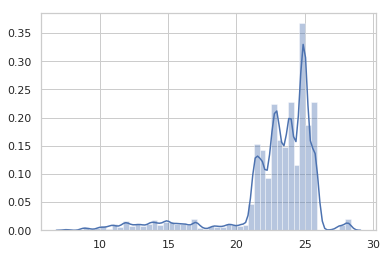

In [61]:
sns.distplot(X_train[['temperature']])

In [62]:
X_train_gau = X_train[['temperature']]
X_test_gau = X_test[['temperature']]
X_train_bern = X_train.drop(columns=['differ_day', 'Age','temperature'], axis=1)
X_test_bern = X_test.drop(columns=['differ_day', 'Age', 'temperature'], axis=1)
X_train_mul = X_train[['differ_day', 'Age']]
X_test_mul = X_test[['differ_day', 'Age']]

X_samp_gau, y_samp_gau = EditedNearestNeighbours(kind_sel="all", n_neighbors=8, random_state=0).fit_sample(X_train_gau, y_train)
X_samp_bern, y_samp_bern = EditedNearestNeighbours(kind_sel="all", n_neighbors=8, random_state=0).fit_sample(X_train_bern, y_train)
X_samp_mul, y_samp_mul = EditedNearestNeighbours(kind_sel="all", n_neighbors=8, random_state=0).fit_sample(X_train_mul, y_train)

weight=sum(y_samp_gau=="No")/sum(y_samp_gau=="Yes")
gau_weight=pd.Series(list(y_samp_gau)).apply(lambda x: weight if x=="Yes" else 1)

weight=sum(y_samp_bern=="No")/sum(y_samp_bern=="Yes")
bern_weight=pd.Series(list(y_samp_bern)).apply(lambda x: weight if x=="Yes" else 1)

weight=sum(y_samp_mul=="No")/sum(y_samp_mul=="Yes")
mul_weight=pd.Series(list(y_samp_mul)).apply(lambda x: weight if x=="Yes" else 1)

gau_model=GaussianNB().fit(X_samp_gau, y_samp_gau, sample_weight=gau_weight)
y_pred_gau=gau_model.predict(X_test_gau)

bern_model=BernoulliNB().fit(X_samp_bern, y_samp_bern, sample_weight=bern_weight)
y_pred_bern=bern_model.predict(X_test_bern)

mul_model=MultinomialNB().fit(X_samp_mul, y_samp_mul, sample_weight=mul_weight)
y_pred_mul=mul_model.predict(X_test_mul)

In [63]:
gau_likelihood=[]
for i in np.arange(X_test_gau.shape[0]):
    gau_likelihood.append([sp.stats.norm(gau_model.theta_[0], np.sqrt(gau_model.sigma_[0])).pdf(np.array(X_test_gau)[i])[0],\
                           sp.stats.norm(gau_model.theta_[1], np.sqrt(gau_model.sigma_[1])).pdf(np.array(X_test_gau)[0])[0]])
gau_likelihood=np.array(gau_likelihood)


bern_theta = np.exp(bern_model.feature_log_prob_)
ls=[]
for i in np.arange(X_test_bern.shape[0]):
    ls.append(list(((bern_theta ** np.array(X_test_bern)[i]) * (1 - bern_theta) ** (1 - np.array(X_test_bern)[i])).prod(axis=1)))
bern_likelihood=np.array(ls)

mul_theta = np.exp(mul_model.feature_log_prob_)
ls=[]
for i in np.arange(X_test_mul.shape[0]):
    ls.append((mul_theta** np.array(X_test_mul)[i]).prod(axis=1))
mul_likelihood=np.array(ls)

p=(mul_likelihood+bern_likelihood+gau_likelihood)*np.exp(bern_model.class_log_prior_)
y_pred=[]
for i in np.arange(p.shape[0]):
    s=list(p[i]/p[i].sum())
    if s[0] > s[1]:
        y_pred.append("No")
    else:
        y_pred.append("Yes")

In [64]:
# 모든 설명 변수 사용
print(""*40)
print(confusion_matrix(y_test, y_pred))
print(""*40)
print(classification_report(y_test, y_pred))


[[17585  7693]
 [ 3269  2867]]

              precision    recall  f1-score   support

          No       0.84      0.70      0.76     25278
         Yes       0.27      0.47      0.34      6136

   micro avg       0.65      0.65      0.65     31414
   macro avg       0.56      0.58      0.55     31414
weighted avg       0.73      0.65      0.68     31414



In [65]:
# 미성년 여성과 청장년 여성 추가
print(""*40)
print(confusion_matrix(y_test, y_pred))
print(""*40)
print(classification_report(y_test, y_pred))


[[17585  7693]
 [ 3269  2867]]

              precision    recall  f1-score   support

          No       0.84      0.70      0.76     25278
         Yes       0.27      0.47      0.34      6136

   micro avg       0.65      0.65      0.65     31414
   macro avg       0.56      0.58      0.55     31414
weighted avg       0.73      0.65      0.68     31414



# lightgbm

In [66]:
%%time
X_samp_lgbm, y_samp_lgbm = EditedNearestNeighbours(kind_sel="all", n_neighbors=8, random_state=0).fit_sample(X_train, y_train)
model_lgbm=lightgbm.LGBMClassifier(n_estimators=100, max_depth=-1, random_state=0)
lgbm_result=model_lgbm.fit(X_samp_lgbm, y_samp_lgbm)
y_pred=lgbm_result.predict(X_test)

CPU times: user 29.1 s, sys: 194 ms, total: 29.3 s
Wall time: 25.8 s


In [67]:
# 모든 설명 변수 사용
print("-"*54)
print(confusion_matrix(y_test, y_pred))
print(""*54)
print(classification_report(y_test, y_pred))

------------------------------------------------------
[[12646 12632]
 [  810  5326]]

              precision    recall  f1-score   support

          No       0.94      0.50      0.65     25278
         Yes       0.30      0.87      0.44      6136

   micro avg       0.57      0.57      0.57     31414
   macro avg       0.62      0.68      0.55     31414
weighted avg       0.81      0.57      0.61     31414



In [68]:
# 미성년 여성과 청년및중년 여성컬럼 추가 사용
print("-"*54)
print(confusion_matrix(y_test, y_pred))
print(""*54)
print(classification_report(y_test, y_pred))

------------------------------------------------------
[[12646 12632]
 [  810  5326]]

              precision    recall  f1-score   support

          No       0.94      0.50      0.65     25278
         Yes       0.30      0.87      0.44      6136

   micro avg       0.57      0.57      0.57     31414
   macro avg       0.62      0.68      0.55     31414
weighted avg       0.81      0.57      0.61     31414



### GrideSearchCV

In [69]:
param_grid = [{"n_estimators": list(range(100, 200, 10)), "max_depth": list(range(10, 35, 5))},
              {"n_estimators": list(range(200, 300, 10)), "max_depth": list(range(10, 35, 5))},
              {"n_estimators": list(range(300, 400, 10)), "max_depth": list(range(10, 35, 5))},
              {"n_estimators": list(range(400, 500, 10)), "max_depth": list(range(10, 35, 5))},
              {"n_estimators": list(range(500, 600, 10)), "max_depth": list(range(10, 35, 5))},]

# 위의 param_grid의 값들을 하나씩 넣어가면서 최상의 param값과 최상의 param값으로 test데이터에 대한 recall값을 리스트 형태로 반환하는 함수
def grid_search(param_grid):
    param_ls = []
    recall_ls = []
    for param in param_grid:
        gs = GridSearchCV(estimator=lightgbm.LGBMClassifier(random_state=0) ,param_grid=param, scoring=f1_scorer, cv=3, n_jobs=2).fit(X_samp_lgbm, y_samp_lgbm)
        best = gs.best_params_
        param_ls.append(best)
        lgb_model = lightgbm.LGBMClassifier(n_estimators=best.get("n_estimators"), 
                                        max_depth=best.get("max_depth"), 
                                        random_state=0).fit(X_samp_lgbm, y_samp_lgbm)
        y_pred = lgb_model.predict(X_test)
        recall = f1_score(y_test, y_pred, pos_label="Yes")
        recall_ls.append(recall)
    return param_ls, recall_ls


In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
f1_scorer = make_scorer(f1_score, pos_label="Yes")

In [71]:
# 함수 실행
param_ls, recall_ls = grid_search(param_grid)

# 함수 결과로는 첫번째 리스트에서 나온 param 값이 test데이터에 대한 최상의 recall값을 뽑아냈음
param_ls, recall_ls

([{'max_depth': 15, 'n_estimators': 180},
  {'max_depth': 20, 'n_estimators': 290},
  {'max_depth': 20, 'n_estimators': 390},
  {'max_depth': 10, 'n_estimators': 490},
  {'max_depth': 25, 'n_estimators': 590}],
 [0.44425880289043895,
  0.4431555499516665,
  0.4443600135089496,
  0.4436706441887129,
  0.4454352441613588])

In [72]:
# 첫번째 데이터 위 아래를 기준으로 다시 param리스트를 만들어 함수에 집어 넣었다.
param_grid = [{"n_estimators": [185, 190, 195], "max_depth": [10, 15, 20, 25, 30]},
              {"n_estimators": [200, 205, 210], "max_depth": [10, 15, 20, 25, 30]}]

# 결과로 n_estimator 200, max_depth 15(recall: 0.4436)가 test 데이터를 가장 잘 예측하였음. 그러나 n_estimator 195, max_depth 15(recall: 0.4433)와 비교했을 때 으로 거의 미미한 차이만을 보임
param_ls, recall_ls = grid_search(param_grid)

param_ls, recall_ls

([{'max_depth': 15, 'n_estimators': 195},
  {'max_depth': 15, 'n_estimators': 210}],
 [0.4446303811237084, 0.4448724927766844])

In [73]:
param_grid = {"n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], "max_depth": [10, 50, 100]}

In [74]:
gs = GridSearchCV(estimator=lightgbm.LGBMClassifier(random_state=0) 
                  ,param_grid=param_grid, scoring="accuracy", cv=10, n_jobs=2)


In [83]:
%%time
gs = gs.fit(X_samp_lgbm, y_samp_lgbm)


CPU times: user 28.1 s, sys: 727 ms, total: 28.9 s
Wall time: 7min 49s


In [84]:
gs.best_score_

0.8899558077363741

In [85]:
gs.best_params_

{'max_depth': 50, 'n_estimators': 1000}

In [86]:
model_lgbm = lightgbm.LGBMClassifier(n_estimators=1000, max_depth=10, random_state=0)

In [89]:
model_result = model_lgbm.fit(X_samp_lgbm, y_samp_lgbm)

In [90]:
y_train_pred = model_result.predict(X_test)

In [91]:
confusion_matrix(y_test, y_train_pred, labels=["Yes", "No"])

array([[ 5200,   936],
       [12043, 13235]])

In [92]:
y_pred = model_result.predict(X_test)

In [93]:
confusion_matrix(y_test, y_pred, labels=["Yes", "No"])

array([[ 5200,   936],
       [12043, 13235]])

In [94]:
accuracy_score(y_test, y_pred)

0.5868402623034316

In [95]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.93      0.52      0.67     25278
         Yes       0.30      0.85      0.44      6136

   micro avg       0.59      0.59      0.59     31414
   macro avg       0.62      0.69      0.56     31414
weighted avg       0.81      0.59      0.63     31414

